# <font color='12284A' style="font-family: andale mono, monospace; font-size: 28px; text-transform: uppercase">Drum Audio Sample Classifier - Model<font><a class='anchor' id='top'></a>
This portion of the application is used to create the model. It imports, and parses the dataset, creates and fits the model, and finally saves the model to be used by the "drum_prediction" jupyter notebook.
    
I would like the recognize and thank Dr. Papia Nandi for her article "CNNs for Audio Classification". Citation comments are included in code snippets directly adapted from her work and proper citations will be included in Task documentation.

In [90]:
#Imports Modules
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [91]:
# Get acbsolute path of project
abs_path = os.getcwd()

# Imports csv of dataset metadata
df = pd.read_csv(abs_path + "/dataset/samples_metadata.csv")

# Defines variables that may be changes in the future

# Number of spectrogram frames to use
LENGTH = 100

# Drum Type Dictionary with indices
drum_types = {
    'clap': 0,
    'closedhat': 1,
    'kick': 2,
    'openhat': 3,
    'snare': 4,
}

In [92]:
# Converts Audio Samples in single Numpy Array to train model

# Gets relative path to audio samples for dataset
samples = abs_path + "/dataset/samples/"

# Create blank lists to fill
samples_data = []
samples_visual_data = []
samples_data_type = []

for sample in sorted(os.listdir(samples)):
    # Blank arrays of zeros to be overwritten by sample data, required to make all sample arrays the same size
    # Array Dimensions are as follows: D1: Pitch Slices (513), D2: Time samples (LENGTH), and D3: value of power/amplitude
    # D3 is duplicated across 3 values in the model version since CNNs were made with RGB (3) image values in mind. It's
    # simpler to make the CNN Model think it is a RGB image than try and make it work for audio specifically
    sample_array = np.zeros((513, LENGTH, 3))
    visual_array = np.zeros((513, LENGTH))
    
    # Load, Trim, and resample the audio file
    audio, sr = librosa.load(samples+sample, sr=22050)
    audio, _ = librosa.effects.trim(audio, top_db=50)
    audio = librosa.resample(y=audio, orig_sr=sr, target_sr=22050)
    
    # Compute stft spectrogram
    stft = librosa.stft(y=audio, n_fft=1024, hop_length=512)
    # Store how many frames this sample uses, capped at LENGTH
    t = min(stft.shape[1], LENGTH)
    # Store raw power in the visual array
    visual_array[:, :t] = stft
    # Convert to db
    stft = librosa.power_to_db(stft, ref=np.max)
    # Store db values in sample array
    sample_array[:, :t, :] = np.repeat(stft[:, :t, np.newaxis], 3, axis=2)
    
    # Adds audio samples data to the list of samples_data, and samples_visual_data
    samples_data.append(sample_array)
    samples_visual_data.append(visual_array)
    
    # Adds audio samples type of drum to samples_data_type
    samples_data_type.append([val for key,val in drum_types.items() if key in sample])

# Convert Lists to Numpy Arrays
samples_data = np.array(samples_data)
samples_visual_data = np.array(samples_visual_data)
samples_data_type = np.array(samples_data_type)

This is our preprocessing step. Anything we do here must be replicated exactly when we want to sample the final model. Except for the visuals related stuff, which is just for testing and sanity checking before we train the model.

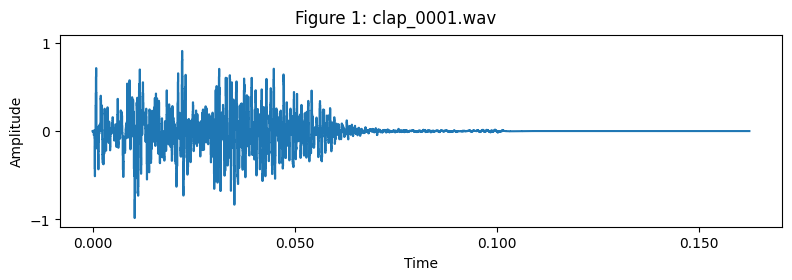

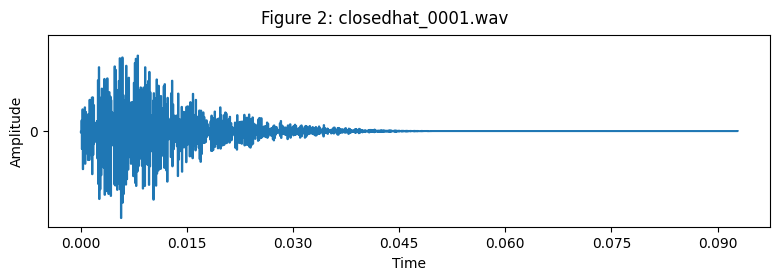

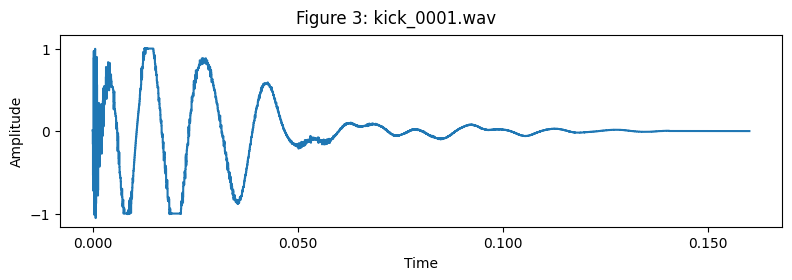

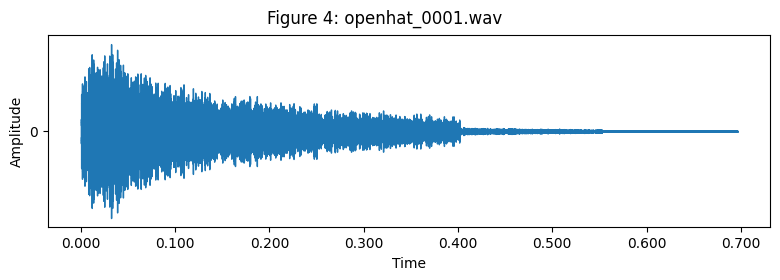

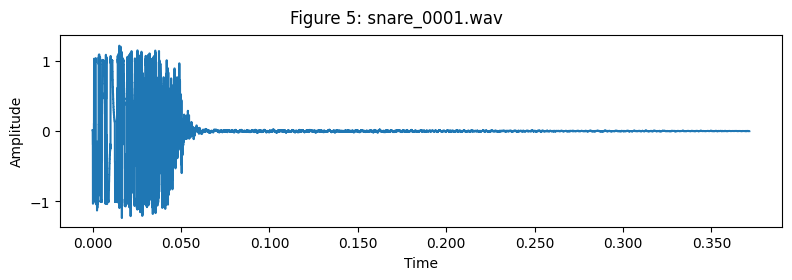

In [93]:
# Outputs Waveform of the first of each Drum Type, conveys amplitude over time
for i, drum in enumerate(drum_types):
    y, sr = librosa.load(samples + drum + '_0001.wav')

    y,z = librosa.effects.trim(y, top_db=50)
    y = librosa.resample(y=y, orig_sr=sr, target_sr=22050)

    plt.figure(figsize=(8, 3))
    plt.suptitle("Figure " + str(i+1) + ": " + drum + '_0001.wav',x=0.5, y=0.915,fontsize=12)
    plt.xlabel("Time")
    plt.ylabel('Amplitude')
    
    plt.xticks(np.arange(0, 1, 1))
    plt.yticks(np.arange(-2, 2, 1))
    plt.tight_layout(pad=1.0)
    
    librosa.display.waveshow(y, sr=sr)

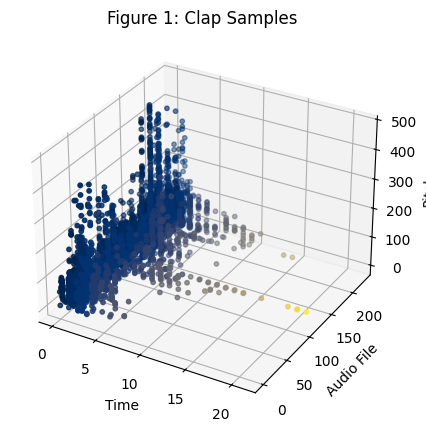

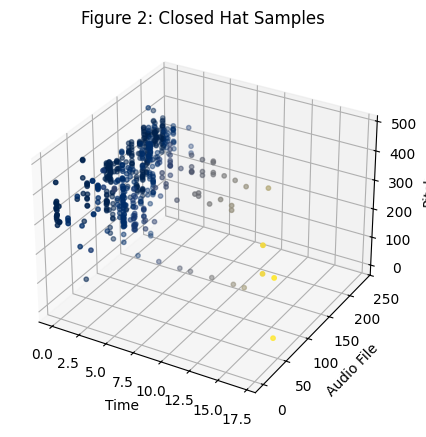

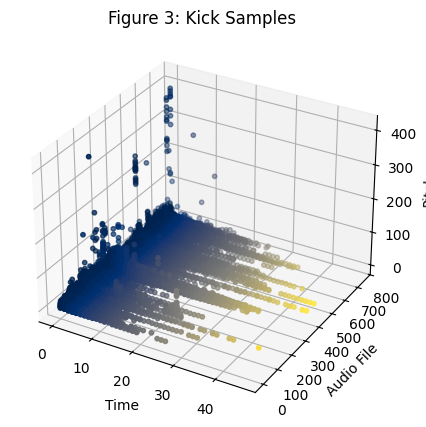

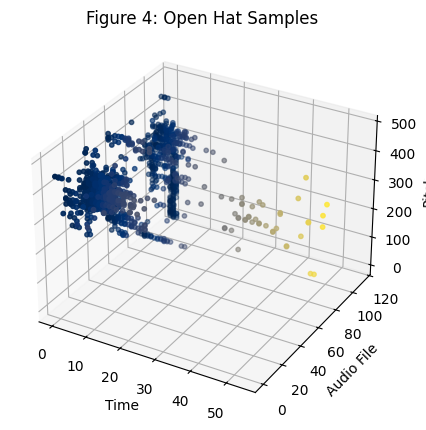

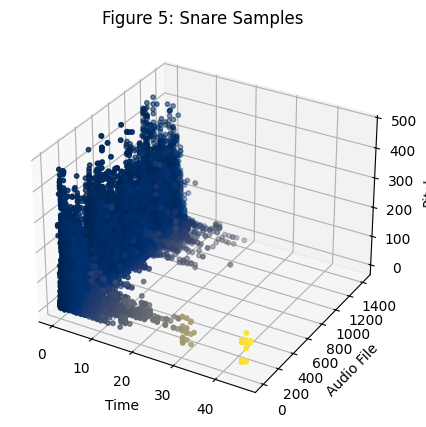

In [94]:
# Outputs Melspectrum of the All of each Drum Type, conveys pitch over time
values = [["Clap Samples", 0, 227],
          ["Closed Hat Samples", 227, 469],
          ["Kick Samples", 469, 1217], 
          ["Open Hat Samples", 1217, 1331],
          ["Snare Samples", 1331, 2746]]

for i, value_set in enumerate(values):
    a = samples_visual_data[value_set[1]:value_set[2]]
    y, z, x = np.nonzero(a > 10)

    fig, ax = plt.subplots(1, 1, figsize = (5, 5), subplot_kw={'projection': '3d'})

    ax.scatter3D(x, y, z, s=10, c=x, cmap='cividis')
    plt.title("Figure " + str(i+1) + ": " + value_set[0])
    plt.xlabel("Time")
    plt.ylabel('Audio File')
    ax.set_zlabel('Pitch')
    
plt.show()

In [95]:
# Split once to get the test and training set
X_train, X_test, y_train, y_test = train_test_split(samples_data, samples_data_type, test_size=0.25, random_state=123)

# Split twice to get the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

This splits the dataset into 3 sets: training (56%), validation (19%), and test (25%)

In [108]:
# Adapted from "CNNs for Audio Classification" by Papia Nandi, 2021

# Adds layers to model
# Conv2D Layers are important for CNNs to learn audio spacial information
# Max Pooling and Dropout Layers help avoid overfitting

def make_norm_layer(input_shape, input):
    norm_layer = layers.Normalization(input_shape=input_shape)
    # computes mean and variance from training set
    norm_layer.adapt(input)
    return norm_layer

model = models.Sequential()
model.add(make_norm_layer((513, LENGTH, 3), X_train))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(513, LENGTH, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(len(drum_types), activation='softmax'))

Normalization layer is included in the model so that normalization parameters are stored inside the model itself.
BatchNormalization layers were added for stability, which seems to have helped a lot.

In [109]:
# Model is compiled. Adam is used to have a automatic learning rate
# Sparse Categorical Crossentropy is used since there are multiple drum types, but only one drum type per drum
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [110]:
# Fits model
history = model.fit(X_train, y_train, epochs=50, validation_data= (X_val, y_val))

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.3744 - loss: 11.5171 - val_accuracy: 0.5243 - val_loss: 2.6356
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.4203 - loss: 15.5990 - val_accuracy: 0.4777 - val_loss: 4.6191
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5181 - loss: 12.6574 - val_accuracy: 0.5670 - val_loss: 6.1861
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.5939 - loss: 11.2930 - val_accuracy: 0.6738 - val_loss: 9.0121
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.6101 - loss: 13.2820 - val_accuracy: 0.5631 - val_loss: 10.7219
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.5946 - loss: 14.8107 - val_accuracy: 0.5670 - val_loss: 16.4197
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6120 - loss: 21.3377 - val_accuracy: 0.5709 - val_loss: 19.9571
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6321 - loss: 23.6100 - val_accura

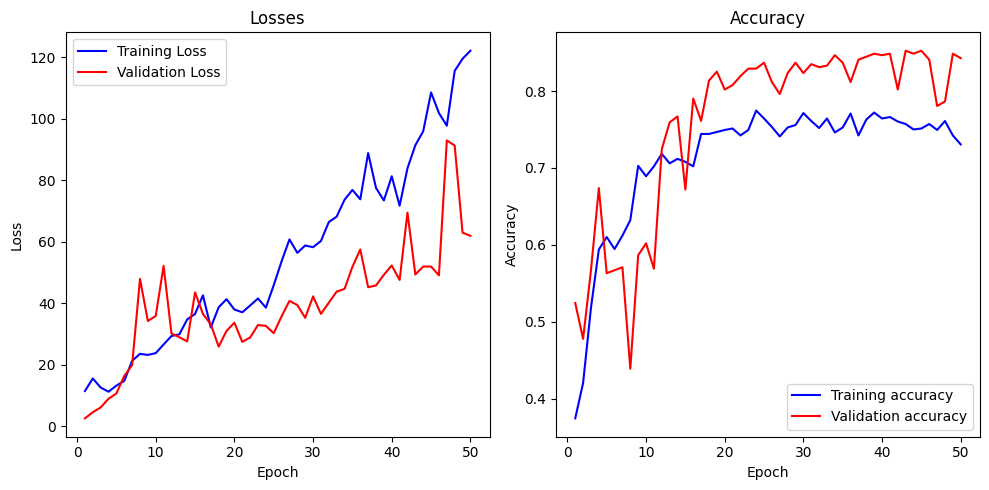

Final Accuracy:  0.7305699586868286
Final Validation Accuracy:  0.8427184224128723


In [111]:
# Adapted from "CNNs for Audio Classification" by Papia Nandi, 2021
# Nandi originally adapted from Deep Learning with Python by Francois Chollet, 2018

# Outputs graphs of Losses and Accuracy of model.
history_dict=history.history
loss_values=history_dict['loss']
accuracy_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_accuracy_values=history_dict['val_accuracy']
epochs=range(1, len(loss_values)+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(epochs,loss_values,'blue',label='Training Loss')
ax1.plot(epochs,val_loss_values,'red', label='Validation Loss')
ax1.set_title('Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs,accuracy_values,'blue', label='Training accuracy')
ax2.plot(epochs,val_accuracy_values,'red',label='Validation accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# Print final accuracy and validation accuracy:
print('Final Accuracy: ', accuracy_values[-1])
print('Final Validation Accuracy: ', val_accuracy_values[-1])

In [100]:
# Saves model to be used by the prediction Jupyter Notebook
model.save('saved_model/model_stft_last.keras')